## **Predicción diaria del precio de las acciones de la minera FSM utilizando Long short-term memory (LSTM)**

**Integrantes del equipo:**
- **Romero Cisneros** - Karlo Brandi
- **Hernandez Bianchi** - Stefano Alessandro 

En este notebook, realizaremos la predicción diaria del precio de cierre de las acciones de la minera FSM (Fortuna Silver Mines Inc.) utilizando una Long short-term memory (LSTM).

### **1. Importación de bibliotecas**

In [27]:
%matplotlib inline
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.dates as mdates
import seaborn as sns  # Para gráficos estadísticos

### **2. Descargar datos**
Descargamos los datos históricos de las acciones de FSM desde Yahoo Finance.

In [28]:
# Descargar datos de Yahoo Finance
data = yf.download("FSM", start="2019-01-01", end="2023-12-31")

# Mostrar las primeras filas de los datos
data.head()

[*********************100%%**********************]  1 of 1 completed

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,3.67,3.77,3.62,3.68,3.68,969400
2019-01-03,3.71,3.82,3.68,3.79,3.79,848300
2019-01-04,3.77,3.84,3.73,3.78,3.78,770400
2019-01-07,3.80,3.84,3.67,3.70,3.70,633800
2019-01-08,3.69,3.87,3.67,3.85,3.85,738800


### **3. Exploración y preprocesamiento de datos**
Exploramos los datos descargados y realizamos preprocesamiento si es necesario.

In [29]:
# Mostrar todos los datos
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,3.67,3.77,3.62,3.68,3.68,969400
2019-01-03,3.71,3.82,3.68,3.79,3.79,848300
2019-01-04,3.77,3.84,3.73,3.78,3.78,770400
2019-01-07,3.80,3.84,3.67,3.70,3.70,633800
2019-01-08,3.69,3.87,3.67,3.85,3.85,738800
...,...,...,...,...,...,...
2023-12-22,4.03,4.15,3.96,3.96,3.96,5210000
2023-12-26,3.98,4.00,3.90,3.98,3.98,1946400
2023-12-27,4.01,4.11,3.97,4.00,4.00,4162500


In [30]:
# Obtener la forma de los datos (número de filas y columnas)
data.shape

(1258, 6)

#### **Información general de los datos**

In [31]:
# Mostrar información general de los datos
print("Información general de los datos:")
print(data.info())

Información general de los datos:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB
None


#### **Estadísticas descriptivas de los datos**

In [32]:
# Mostrar estadísticas descriptivas de los datos
print("\nEstadísticas descriptivas de los datos:")
print(data.describe())


Estadísticas descriptivas de los datos:
              Open         High          Low        Close    Adj Close  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean      4.174300     4.272091     4.064094     4.164523     4.164523   
std       1.513419     1.546329     1.466581     1.508172     1.508172   
min       1.660000     2.180000     1.470000     1.800000     1.800000   
25%       3.152500     3.220000     3.080000     3.160000     3.160000   
50%       3.710000     3.780000     3.630000     3.700000     3.700000   
75%       4.480000     4.620000     4.330000     4.460000     4.460000   
max       9.480000     9.850000     9.120000     9.540000     9.540000   

             Volume  
count  1.258000e+03  
mean   3.736393e+06  
std    2.280113e+06  
min    2.466000e+05  
25%    2.343275e+06  
50%    3.372650e+06  
75%    4.658625e+06  
max    3.585730e+07  


### **4. Visualización de datos**

Visualizamos los datos para comprender mejor su distribución y tendencias.

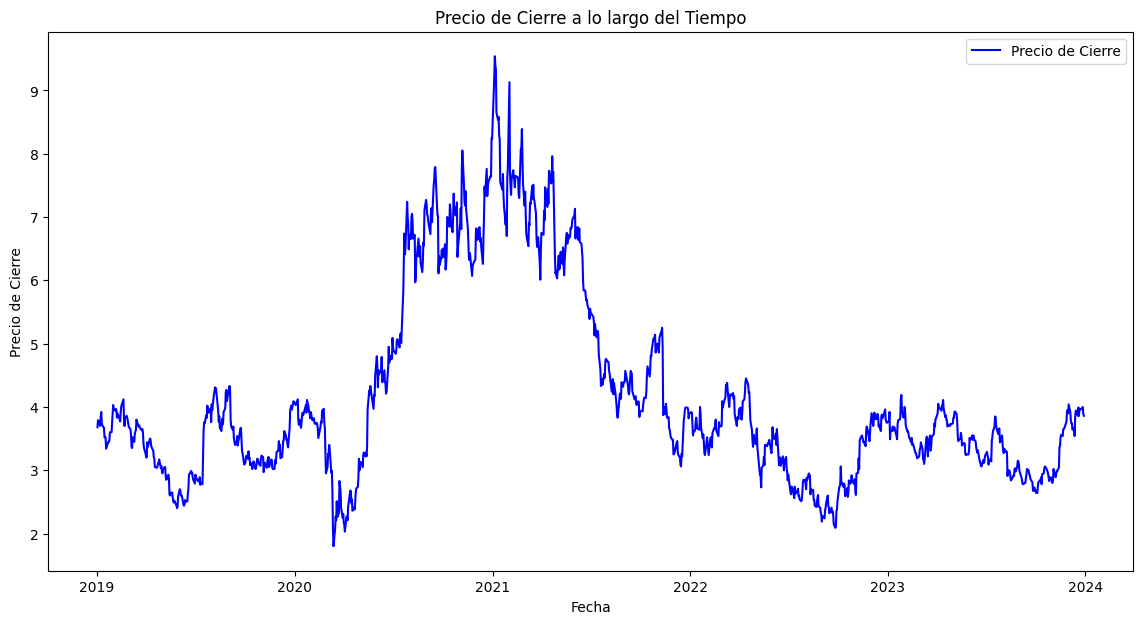

In [33]:
# Graficar el precio de cierre a lo largo del tiempo
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Precio de Cierre', color='blue')
plt.title('Precio de Cierre a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

#### **Histograma**

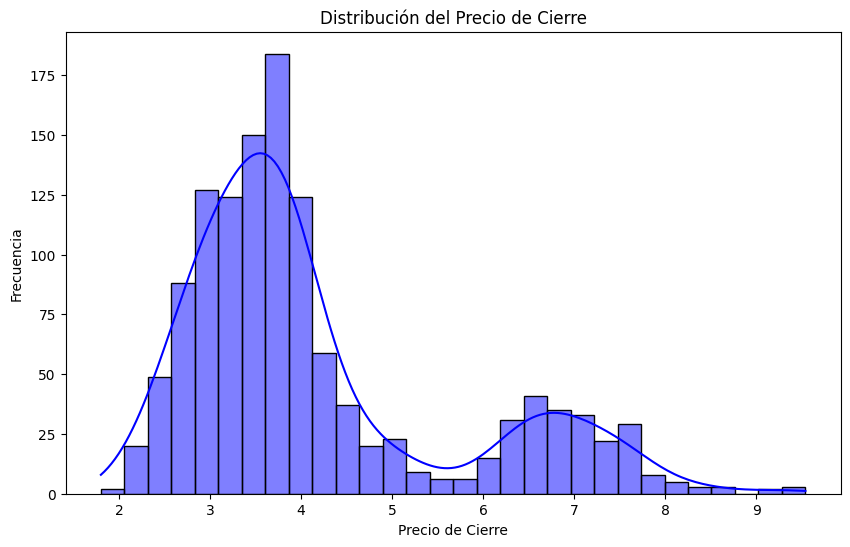

In [34]:
# Graficar la distribución del precio de cierre
plt.figure(figsize=(10, 6))
sns.histplot(data['Close'], bins=30, kde=True, color='blue')
plt.title('Distribución del Precio de Cierre')
plt.xlabel('Precio de Cierre')
plt.ylabel('Frecuencia')
plt.show()

#### **Matriz de Correlación**

In [35]:
# Calcular la matriz de correlación entre las variables del conjunto de datos
data.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998105,0.997833,0.995443,0.995443,0.082039
High,0.998105,1.000000,0.997531,0.997901,0.997901,0.096713
Low,0.997833,0.997531,1.000000,0.998080,0.998080,0.060505
Close,0.995443,0.997901,0.998080,1.000000,1.000000,0.075692
Adj Close,0.995443,0.997901,0.998080,1.000000,1.000000,0.075692
Volume,0.082039,0.096713,0.060505,0.075692,0.075692,1.000000


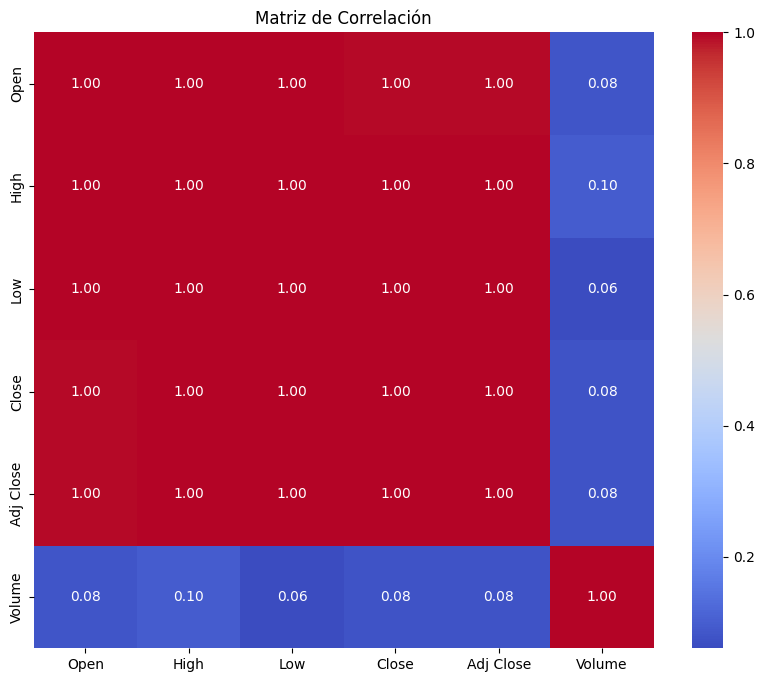

In [36]:
# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))  # Establecer el tamaño de la figura
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")  # Crear el mapa de calor con anotaciones y formato decimal de dos lugares
plt.title('Matriz de Correlación')  # Establecer el título del gráfico
plt.show()  # Mostrar el gráfico

### **5. Preparación de datos para el modelo**
Preparamos los datos para el entrenamiento del modelo, incluyendo la normalización.

In [37]:
def clean_data(data):
    data = data.dropna()
    return data

def normalize_data(data):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    return pd.DataFrame(data_scaled, columns=data.columns), scaler

def select_features(X, y, num_features):
    mutual_info = mutual_info_regression(X, y)
    k_best = SelectKBest(score_func=f_regression, k=num_features).fit(X, y)
    features = X.columns[k_best.get_support(indices=True)]
    return features.tolist()

In [38]:
# Limpiar y Normalizar
data = clean_data(data)
data, scaler = normalize_data(data)

### **6. División en conjuntos de entrenamiento y prueba**

#### **Separar los datos en características (X) y variable objetivo (y)**

In [39]:
# Seleccionar Variables
target_column = 'Close'
num_features = 4  # Número de características a seleccionar
selected_features = select_features(data.drop(columns=[target_column]), data[target_column], num_features)
selected_features.append(target_column)
data = data[selected_features]

In [40]:
# Separar características y objetivo
X = data.drop(columns=[target_column])
y = data[target_column]

#### **Separar los datos en conjuntos de entrenamiento y prueba**

In [41]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [42]:
# Imprimir la forma (shape) de la matriz de características X_train (conjunto de entrenamiento)
print(X_train.shape)

(1006, 4)


In [43]:
# Imprimir la forma (shape) del vector de la variable objetivo y_train (conjunto de entrenamiento)
print(y_train.shape)

(1006,)


In [44]:
# Imprimir la forma (shape) de la matriz de características X_test (conjunto de prueba)
print(X_test.shape)

(252, 4)


In [45]:
# Imprimir la forma (shape) del conjunto de prueba de la variable objetivo (y_test)
print(y_test.shape)

(252,)


### **7. Definición y entrenamiento del modelo LSTM**

In [46]:
# Crear el modelo training LSTM
def train_lstm(X_train, y_train, input_shape):
    """
    Función para entrenar un modelo LSTM.

    Parámetros:
    X_train (numpy array): Conjunto de datos de entrenamiento (características).
    y_train (numpy array): Conjunto de datos de entrenamiento (objetivo).
    input_shape (tuple): Forma de los datos de entrada.

    Retorna:
    model (Sequential): Modelo LSTM entrenado.
    """
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2)

    return model

In [47]:
# Los datos de entrenamiento y prueba se reestructuran en un formato 3D requerido por LSTM (samples, timesteps, features)
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [48]:
# Entrenamos el modelo LSTM usando los datos de entrenamiento reestructurados
lstm_model = train_lstm(X_train_lstm, y_train, (1, X_train.shape[1]))

Epoch 1/500


c:\Users\karlo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1462 - val_loss: 0.0047
Epoch 2/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0446 - val_loss: 0.0270
Epoch 3/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138 - val_loss: 0.0096
Epoch 4/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 5/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 6/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 7/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 8.2913e-04
Epoch 8/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 5.5636e-04
Epoch 9/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 5.6551e-04
Epoch 10/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 4.6584e-04
Epoch 11/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 5.5456e-04
Epoch 12/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

In [49]:
# Guardar el modelo
import joblib
joblib.dump(lstm_model, 'lstm_model.pkl')

['lstm_model.pkl']

### **7. Evaluación del modelo**
Evaluamos el modelo utilizando métricas como el MAPE y el RMSE.

In [50]:
# Generamos predicciones sobre los datos de prueba usando el modelo LSTM entrenado
lstm_predictions = pd.Series(lstm_model.predict(X_test_lstm).flatten(), index=X_test.index)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


#### **Comparación entre Predicciones y Valores Reales del Conjunto de Prueba**

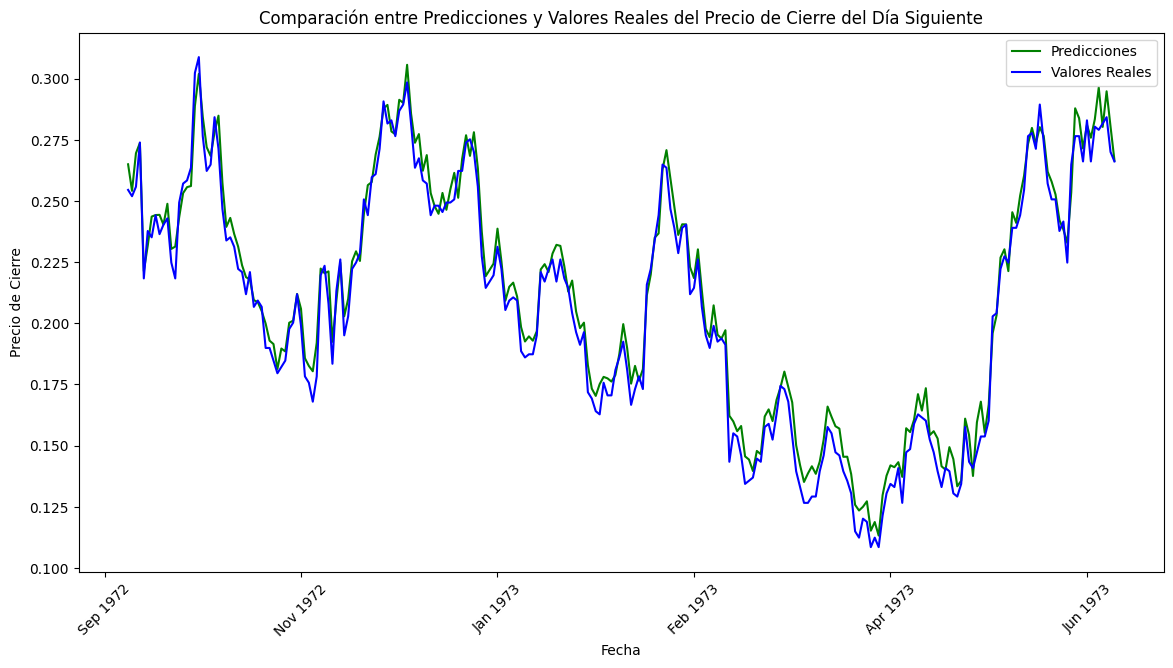

In [51]:
# Visualización de los resultados
plt.figure(figsize=(14, 7))  # Tamaño de la figura
plt.plot(data.index[-len(lstm_predictions):], lstm_predictions,  # Graficar predicciones
         label='Predicciones', color='green')
plt.plot(data.index[-len(y_test):], y_test,  # Graficar valores reales
         label='Valores Reales', color='blue')
plt.title('Comparación entre Predicciones y Valores Reales del Precio de Cierre del Día Siguiente')  # Título del gráfico
plt.xlabel('Fecha')  # Etiqueta del eje x
plt.ylabel('Precio de Cierre')  # Etiqueta del eje y
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Formato de las fechas en el eje x
plt.xticks(rotation=45)  # Rotación de las etiquetas del eje x para una mejor visualización
plt.legend()  # Mostrar leyenda
plt.show()  # Mostrar el gráfico

#### **Metrica de errores**

In [52]:
# Calculamos el MAPE (Mean Absolute Percentage Error) para evaluar la precisión del modelo
mape_lstm = mean_absolute_percentage_error(y_test, lstm_predictions)
# Calculamos el RMSE (Root Mean Squared Error) para evaluar el error del modelo
rmse_lstm = np.sqrt(mean_squared_error(y_test, lstm_predictions))

# Imprimimos las métricas de validación
print(f'MAPE para el modelo LSTM: {mape_lstm}')
print(f'RMSE para el modelo LSTM: {rmse_lstm}')

MAPE para el modelo LSTM: 0.03341246554647968
RMSE para el modelo LSTM: 0.007321165500315122
